In [ ]:
!pip install -q SimpleITK pandas gdown
!pip install -q pyradiomics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 46.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 23.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 3.1 MB/s eta 0:00:00


In [ ]:
# ---------------------------------------------------------------------------------
# ETAPA 2: DOWNLOAD DO ARQUIVO ZIP
# ---------------------------------------------------------------------------------
import gdown

print("\n ETAPA 2 de 5: Baixando o arquivo do Google Drive...")

# O link que você forneceu
id_do_arquivo = "1MFMC16xaHNLVT8Fq3orJuGXIoweQtjDO"
#  ao arquivo salvo no Colab
caminho_arquivo_zip = 'dados_baixados.zip'

gdown.download(id=id_do_arquivo, output=caminho_arquivo_zip, quiet=False)

print(f" Arquivo baixado com sucesso como '{caminho_arquivo_zip}'!")


 ETAPA 2 de 5: Baixando o arquivo do Google Drive...


Downloading...
From (original): https://drive.google.com/uc?id=1MFMC16xaHNLVT8Fq3orJuGXIoweQtjDO
From (redirected): https://drive.google.com/uc?id=1MFMC16xaHNLVT8Fq3orJuGXIoweQtjDO&confirm=t&uuid=bb5d7417-47e6-4d27-92ff-443940b0b5d1
To: /content/dados_baixados.zip
100%|██████████| 38.2M/38.2M [00:01<00:00, 28.1MB/s]

 Arquivo baixado com sucesso como 'dados_baixados.zip'!


In [ ]:
# ---------------------------------------------------------------------------------
# ETAPA 3: DESCOMPACTAR O ARQUIVO E LISTAR O CONTEÚDO
# ---------------------------------------------------------------------------------
import os

print("\n ETAPA 3 de 5: Descompactando o arquivo de dados...")
diretorio_destino = '/content/dados_extraidos/'

if not os.path.exists(diretorio_destino):
    os.makedirs(diretorio_destino)

if os.path.exists(caminho_arquivo_zip):
    !unzip -q "{caminho_arquivo_zip}" -d "{diretorio_destino}"
    print(f" Arquivo descompactado com sucesso na pasta: {diretorio_destino}")

    # --- NOVO: Listando os arquivos extraídos para te ajudar! ---
    arquivos_extraidos = os.listdir(diretorio_destino)
    print("\n   Conteúdo da pasta extraída:")
    for arquivo in arquivos_extraidos:
        print(f"   -> {arquivo}")

else:
    print(f"ERRO: O download do arquivo ZIP falhou.")


 ETAPA 3 de 5: Descompactando o arquivo de dados...
 Arquivo descompactado com sucesso na pasta: /content/dados_extraidos/

   Conteúdo da pasta extraída:
   -> fold1
   -> fold2
   -> fold5
   -> fold3
   -> fold4


In [ ]:
# Cria o diretório 'src'
!mkdir -p src


In [ ]:
%%writefile src/data_manager.py
import os
import pandas as pd
import SimpleITK as sitk
from tqdm.notebook import tqdm
import re

class DataManager:
    """
    Gerencia o mapeamento de imagens e máscaras, e a associação de metadados
    como ID do paciente, classe e fold.
    Também é responsável por gerar as máscaras Otsu se elas não existirem.
    """
    def __init__(self, base_data_dir, masks_output_dir):
        self.base_data_dir = base_data_dir
        self.masks_output_dir = masks_output_dir
        self.df_mapped_data = None

        # Cria o diretório de máscaras se ele não existir
        os.makedirs(self.masks_output_dir, exist_ok=True)
        print(f" Diretório para máscaras Otsu: {self.masks_output_dir}")

    def _generate_otsu_mask(self, image_path, mask_output_path):
        """
        Gera uma máscara Otsu para uma imagem DICOM e a salva.
        Retorna True se a máscara foi gerada com sucesso, False caso contrário.
        """
        try:
            image = sitk.ReadImage(image_path, sitk.sitkFloat32)
            otsu_mask = sitk.OtsuThreshold(image, 0, 1) # outsideValue=0, insideValue=1
            otsu_mask = sitk.Cast(otsu_mask, sitk.sitkUInt8)

            # Copia a informação geométrica para garantir o alinhamento
            otsu_mask.SetOrigin(image.GetOrigin())
            otsu_mask.SetSpacing(image.GetSpacing())
            otsu_mask.SetDirection(image.GetDirection())

            sitk.WriteImage(otsu_mask, mask_output_path)
            return True
        except Exception as e:
            print(f"        Erro ao gerar máscara Otsu para {os.path.basename(image_path)}: {e}")
            return False

    def map_and_generate_masks(self):
        """
        Percorre os diretórios de folds e pacientes para encontrar imagens originais.
        Para cada imagem, verifica se a máscara Otsu existe; se não, a gera.
        Mapeia os caminhos da imagem original e da máscara Otsu.
        """
        all_image_mask_data = []
        print(f"\n Iniciando mapeamento e verificação/geração de máscaras em '{self.base_data_dir}'...")

        # Coleta todos os caminhos de imagens DICOM primeiro, para usar com tqdm
        all_original_image_paths = []
        # Percorre as pastas de fold (ex: fold1, fold2)
        for fold_name in sorted(os.listdir(self.base_data_dir)):
            fold_path = os.path.join(self.base_data_dir, fold_name)
            # Verifica se é um diretório e começa com 'fold'
            if os.path.isdir(fold_path) and fold_name.startswith('fold'):
                # Percorre as pastas de paciente dentro de cada fold
                for patient_id in sorted(os.listdir(fold_path)):
                    patient_folder_path = os.path.join(fold_path, patient_id)
                    if os.path.isdir(patient_folder_path):
                        # Percorre os arquivos dentro da pasta do paciente
                        for original_filename in os.listdir(patient_folder_path):
                            # Verifica se é um arquivo de imagem DICOM, NIfTI ou MHA
                            if original_filename.lower().endswith(('.dcm', '.nii', '.nii.gz', '.mha')):
                                all_original_image_paths.append({
                                    'path': os.path.join(patient_folder_path, original_filename),
                                    'patient_id': patient_id,
                                    'fold_name': fold_name,
                                    'original_filename': original_filename
                                })

        if not all_original_image_paths:
            print("\n ERRO: Nenhuma imagem original encontrada para processamento.")
            return None

        # Itera sobre os arquivos de imagem com uma barra de progresso
        for img_info in tqdm(all_original_image_paths, desc="Mapeando e Gerando Máscaras Otsu"):
            original_image_path = img_info['path']
            patient_id = img_info['patient_id']
            fold_name = img_info['fold_name']
            original_filename = img_info['original_filename']

            base_name_without_ext = os.path.splitext(original_filename)[0]
            mask_filename = f"{base_name_without_ext}_otsu.nii.gz"
            mask_path = os.path.join(self.masks_output_dir, mask_filename)

            # Se a máscara não existir, tenta gerá-la
            if not os.path.exists(mask_path):
                if not self._generate_otsu_mask(original_image_path, mask_path):
                    continue # Pula para a próxima imagem se a geração da máscara falhar

            # Tenta extrair a classe da parte final do nome do arquivo (ex: _0.dcm, _1.dcm)
            class_label = -1 # Valor padrão se não encontrar
            match = re.search(r'_(\d+)\.(dcm|nii|nii\.gz|mha)$', original_filename, re.IGNORECASE)
            if match:
                class_label = int(match.group(1))

            all_image_mask_data.append({
                'patient_id': patient_id,
                'class_label': class_label,
                'fold': fold_name,
                'original_path': original_image_path,
                'mask_path': mask_path
            })

        self.df_mapped_data = pd.DataFrame(all_image_mask_data)

        if self.df_mapped_data.empty:
            print("\n ERRO: Nenhum par imagem-máscara processado com sucesso.")
            return None

        print(f"\nMapeamento e geração de máscaras concluídos! Total de pares processados: {len(self.df_mapped_data)}")
        print("\n Amostra do mapeamento final:")
        print(self.df_mapped_data.head())
        return self.df_mapped_data

Writing src/data_manager.py


In [ ]:
%%writefile src/radiomics_extractor.py
from radiomics import featureextractor

class RadiomicsExtractor:
    """
    Encapsula a configuração e execução da extração de características PyRadiomics.
    """
    def __init__(self, params):
        self.params = params
        self.extractor = None
        print(" Configuração do PyRadiomics definida (sem características de forma).")
        self._initialize_extractor()

    def _initialize_extractor(self):
        """Inicializa o extrator PyRadiomics."""
        try:
            self.extractor = featureextractor.RadiomicsFeatureExtractor(self.params)
        except Exception as e:
            print(f" Erro ao inicializar o extrator: {e}")
            raise # Re-levanta a exceção, pois sem o extrator não podemos continuar

    def extract_features(self, image_path, mask_path):
        """
        Executa a extração de características para um único par imagem-máscara.
        Retorna um dicionário de características limpas.
        """
        if not self.extractor:
            raise RuntimeError("Extrator PyRadiomics não inicializado.")

        feature_vector = self.extractor.execute(image_path, mask_path)

        # Remove metadados e informações diagnósticas
        clean_features = {
            key: val for key, val in feature_vector.items()
            if not key.startswith('diagnostics')
        }
        return clean_features

Writing src/radiomics_extractor.py


In [ ]:
%%writefile src/pipeline_runner.py
import os
import pandas as pd
from tqdm.notebook import tqdm

# Importa as classes dos outros módulos no mesmo pacote 'src'
from src.data_manager import DataManager
from src.radiomics_extractor import RadiomicsExtractor

class PipelineRunner:
    """
    Orquestra o pipeline completo de extração de características radiômicas.
    """
    def __init__(self, base_data_dir, masks_output_dir, output_csv_path, radiomics_params):
        self.data_manager = DataManager(base_data_dir, masks_output_dir)
        self.radiomics_extractor = RadiomicsExtractor(radiomics_params)
        self.output_csv_path = output_csv_path
        self.df_features = None

    def run(self):
        """Executa o pipeline completo: mapeamento, extração e salvamento."""

        # 1. Mapeamento de Dados e Geração de Máscaras
        df_final_map = self.data_manager.map_and_generate_masks()
        if df_final_map is None:
            print("Pipeline abortado devido a falha no mapeamento ou geração de máscaras.")
            return

        # 2. Extração de Características
        all_features_list = []
        print("\n Iniciando extração de características para todos os pacientes...")

        for index, row in tqdm(df_final_map.iterrows(), total=len(df_final_map), desc="Extraindo Características"):
            image_path = row['original_path']
            mask_path = row['mask_path']
            patient_id = row['patient_id']
            class_label = row['class_label']
            fold_name = row['fold']
            original_filename = os.path.basename(image_path)

            try:
                clean_features = self.radiomics_extractor.extract_features(image_path, mask_path)

                # Adiciona informações de identificação
                clean_features['patient_id'] = patient_id
                clean_features['class_label'] = class_label
                clean_features['fold'] = fold_name
                clean_features['original_filename'] = original_filename

                all_features_list.append(clean_features)

            except Exception as e:
                print(f" Erro ao processar {original_filename} (Paciente: {patient_id}, Fold: {fold_name}): {e}")

        if not all_features_list:
            print("\n ERRO: Nenhuma característica foi extraída com sucesso. Verifique os logs de erro acima.")
            return

        self.df_features = pd.DataFrame(all_features_list)

        # 3. Reorganiza e Salva o DataFrame Final
        self._reorder_and_save_features()

    def _reorder_and_save_features(self):
        """Reorganiza as colunas e salva o DataFrame de características."""

        if self.df_features is None or self.df_features.empty:
            print("Não há características para reorganizar ou salvar.")
            return

        desired_first_columns = ['patient_id', 'class_label', 'fold', 'original_filename']
        other_columns = [col for col in self.df_features.columns if col not in desired_first_columns]
        new_column_order = desired_first_columns + other_columns

        # Garante que todas as colunas desejadas existam no DataFrame
        new_column_order = [col for col in new_column_order if col in self.df_features.columns]

        self.df_features = self.df_features[new_column_order]

        self.df_features.to_csv(self.output_csv_path, index=False)

        print(f"\n Extração completa de {len(self.df_features)} pacientes!")
        print(f"Características de todos os pacientes salvas em: {self.output_csv_path}")
        print("\n Primeiras 5 linhas do DataFrame final (com Patient ID, Class Label e Fold no início):")
        print(self.df_features.head())

Writing src/pipeline_runner.py


In [ ]:
%%writefile main.py
import os
import sys

# Adiciona o diretório 'src' ao sys.path para permitir importações
# A pasta 'src' será criada na raiz do ambiente /content/
sys.path.insert(0, './src')

from src.pipeline_runner import PipelineRunner

# --- CONFIGURAÇÃO DE DIRETÓRIOS ---
# Os dados descompactados do .tar estarão
BASE_DATA_DIR = '/content/dados_extraidos/'
MASKS_OTSU_DIR = '/content/masks_otsu_generated/' # Diretório onde as máscaras Otsu serão salvas/procuradas
OUTPUT_FEATURES_CSV = '/content/radiomic_database.csv' # CSV de saída final
# --- FIM DA CONFIGURAÇÃO DE DIRETÓRIOS ---

# --- Configuração de parâmetros do PyRadiomics (sem características de forma) ---
radiomics_params = {
    'setting': {
        'force2D': True,
        'force2Ddimension': 0
    },
    'featureClass': {
        'shape': None,
        'shape2D': None,
        'firstorder': None,

    }
}

# --- EXECUTAR O PIPELINE ---
if __name__ == "__main__":
    # Instancia e roda o pipeline
    runner = PipelineRunner(
        base_data_dir=BASE_DATA_DIR,
        masks_output_dir=MASKS_OTSU_DIR,
        output_csv_path=OUTPUT_FEATURES_CSV,
        radiomics_params=radiomics_params
    )
    runner.run()

    print("\n--- Processo concluído ---")
    print(f"Resultados esperados em: {OUTPUT_FEATURES_CSV}")
    print(f"Máscaras geradas em: {MASKS_OTSU_DIR}")

Overwriting main.py


In [ ]:
# Executa o script principal
!python main.py

A saída de streaming foi truncada nas últimas 5000 linhas.
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
G

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Carrega os dados e prepara os folds
df = pd.read_csv('/content/radiomic_database.csv')

# Garante que os folds são numéricos (ex: 'fold1' vira 1)
df = df[df['class_label'] != 6]  # Remove a classe 6
df['fold'] = df['fold'].str.extract('(\d+)').astype(int)  # Extrai o número do fold


# Lista para armazenar métricas de cada fold
results = []
all_class_labels = sorted(df['class_label'].unique())

# 3. Loop sobre cada fold (1 a 5)
for fold in sorted(df['fold'].unique()):
    print(f"\n=== Fold {fold} ===")

    # Divisão treino/teste baseada no fold atual
    X_train = df[df['fold'] != fold].drop(columns=['patient_id', 'class_label', 'fold', 'original_filename'])
    y_train = df[df['fold'] != fold]['class_label']

    X_test = df[df['fold'] == fold].drop(columns=['patient_id', 'class_label', 'fold', 'original_filename'])
    y_test = df[df['fold'] == fold]['class_label']

    # Normalização
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # KNN
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)

    # Gera o relatório como um dicionário para ter controle sobre a impressão
    report_dict = classification_report(y_test, y_pred, labels=all_class_labels, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test, y_pred, labels=all_class_labels)

    # Cálculo da especificidade por classe
    specificities = {}
    for i, class_label in enumerate(all_class_labels):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0
        specificities[str(class_label)] = specificity

    # Salva os resultados do fold
    fold_results = {
        'fold': fold,
        'report': report_dict,
        'confusion_matrix': cm,
        'specificity': specificities
    }
    results.append(fold_results)

    # Impressão do relatório do fold, sem as linhas de média
    print(f"{'':<12}{'precision':>10}{'recall':>10}{'f1-score':>10}{'support':>10}")
    print("-" * 55)
    for cls_label in all_class_labels:
        cls_str = str(cls_label)
        if cls_str in report_dict:
            metrics = report_dict[cls_str]
            nome_classe = f"Classe {cls_str}"
            print(f"{nome_classe:<12}{metrics['precision']:>10.2f}{metrics['recall']:>10.2f}{metrics['f1-score']:>10.2f}{metrics['support']:>10.0f}")

    print("-" * 55)
    # Imprime a acurácia separadamente
    accuracy = report_dict['accuracy']
    total_support = sum(report_dict[str(cls)]['support'] for cls in all_class_labels)
    print(f"{'accuracy':<12}{'':>10}{'':>10}{accuracy:>10.2f}{total_support:>10.0f}")


# 4. Consolidação das métricas
avg_metrics = {}
for cls in all_class_labels:
    cls_str = str(cls)
    # Coleta as métricas de cada fold, usando 0 se uma classe não aparecer no relatório de um fold
    precision = np.mean([r['report'].get(cls_str, {}).get('precision', 0) for r in results])
    recall = np.mean([r['report'].get(cls_str, {}).get('recall', 0) for r in results])
    f1 = np.mean([r['report'].get(cls_str, {}).get('f1-score', 0) for r in results])
    specificity = np.mean([r['specificity'].get(cls_str, 0) for r in results])

    avg_metrics[f'Classe {cls}'] = {
        'Precisao': precision,
        'Recall': recall,
        'Especificidade': specificity,
        'F1-Score': f1
    }


# 5. Criação e impressão do DataFrame com as métricas médias
print("\n" + "="*35)
print("=== MÉTRICAS FINAIS (MÉDIAS) ===")
print("="*35)

# Converte o dicionário de médias em um DataFrame do pandas
df_resultados_finais = pd.DataFrame.from_dict(avg_metrics, orient='index')

# Arredonda os valores para 2 casas decimais
df_resultados_finais = df_resultados_finais.round(2)

# Imprime o DataFrame resultante
print(df_resultados_finais)


=== Fold 1 ===
             precision    recall  f1-score   support
-------------------------------------------------------
Classe 0          0.98      0.98      0.98       563
Classe 1          0.41      0.87      0.56       164
Classe 2          0.00      0.00      0.00        58
Classe 3          0.70      0.43      0.54       394
Classe 4          0.85      0.79      0.82       450
Classe 5          0.44      0.50      0.46       263
-------------------------------------------------------
accuracy                              0.72      1892

=== Fold 2 ===
             precision    recall  f1-score   support
-------------------------------------------------------
Classe 0          0.98      0.98      0.98       453
Classe 1          0.55      0.77      0.64       502
Classe 2          0.00      0.00      0.00         3
Classe 3          0.59      0.93      0.72       275
Classe 4          0.94      0.75      0.83       973
Classe 5          0.96      0.87      0.91      2198
-----

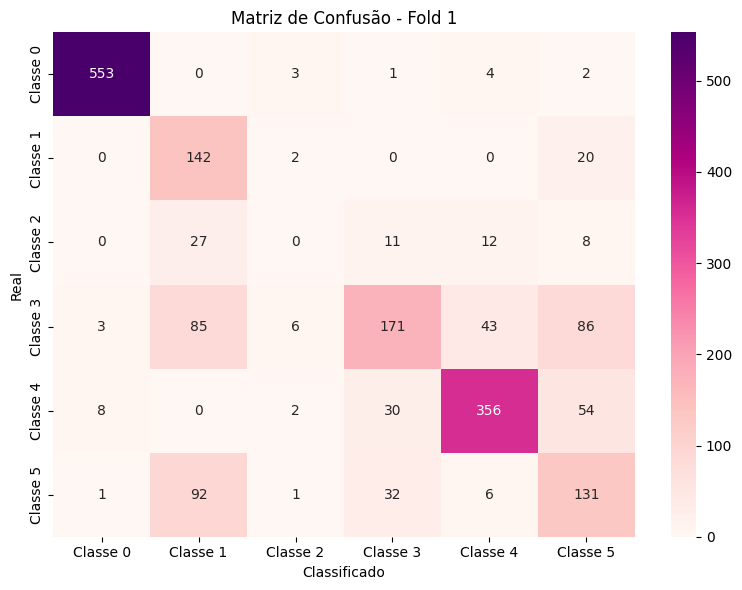

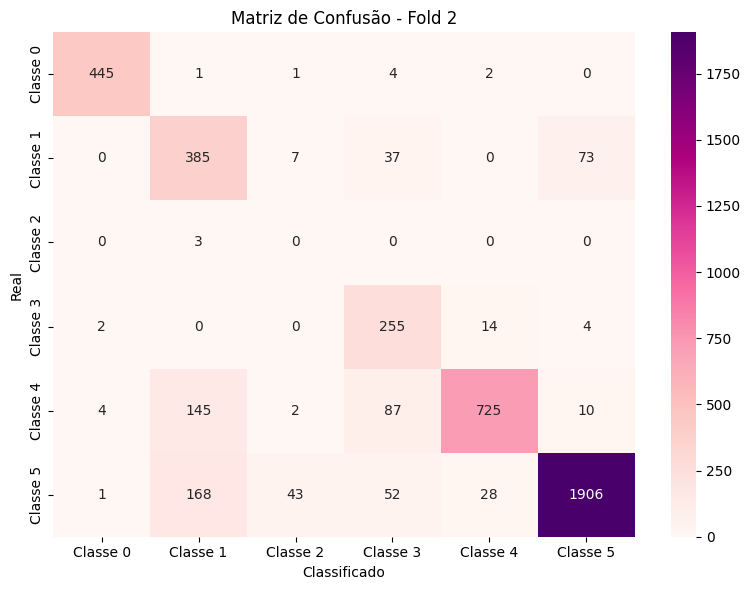

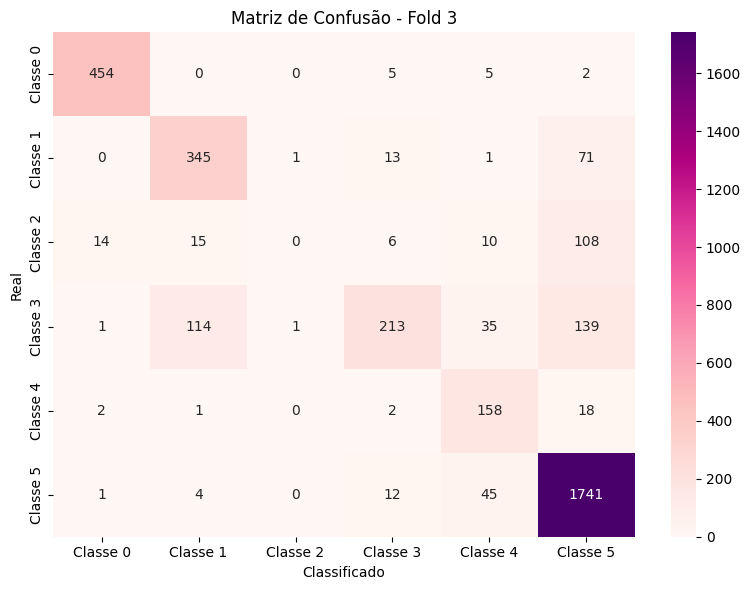

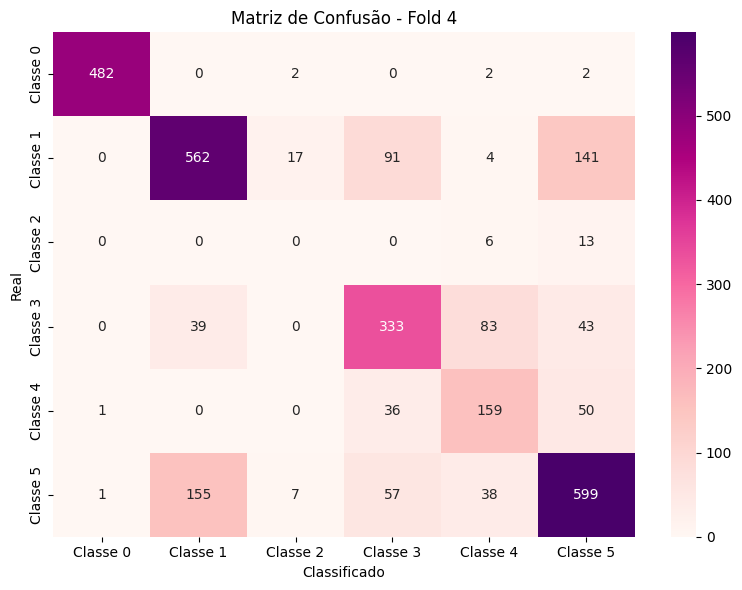

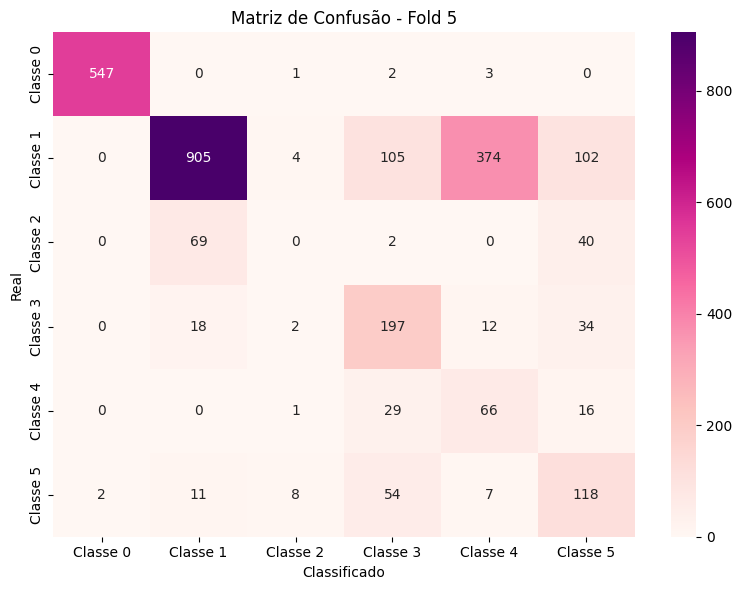

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Número de classes
num_classes = results[0]['confusion_matrix'].shape[0]
class_names = [f"Classe {i}" for i in range(num_classes)]

# Uma matriz de confusão por fold
for fold_result in results:
    fold_num = fold_result['fold']
    cm = fold_result['confusion_matrix']

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Matriz de Confusão - Fold {fold_num}")
    plt.xlabel("Classificado")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()
